# Visual Inspection of Motorcycle Connecting Rods


Importing the necessary libraries 

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from statistics import mean
import random as rand

Grabbing the image

In [2]:
image = cv2.imread('ispezione-bielle-immagini/TESI92.BMP',cv2.IMREAD_GRAYSCALE)

Visualizing the grabbed image

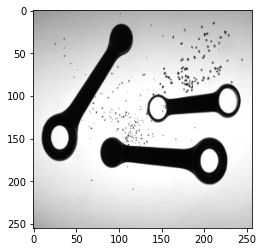

In [3]:
plt.imshow(image, cmap='gray', vmin=0, vmax=255);

# Image denoising (task 2 point 3)

In order to remove the iron powder, a median filter has been applied. This type of non-linear filter is used to counteract impulse noise and in this scenario the iron powder falls exactly in this noise category.   
The most important characteristic of this type of filter is that it does not introduce new values like mean filters do. Indeed, it preserves edges by choosing either one value in the high side of the edge or one value in the low side.  
The mean filter has been applied $10$ times with a $3 \times 3$ kernel in order to remove the iron powder. 

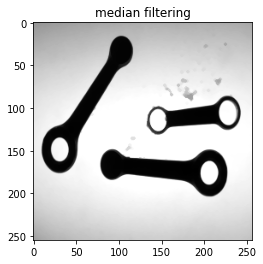

In [4]:
def denoising(img, kernel_size, max_iter):
    iterations = 0
    current_img = img.copy()
    last_iter_img = np.zeros(img.size)
    
    while not np.array_equal(np.array(current_img), np.array(last_iter_img)) and iterations <= max_iter:
        iterations += 1
        last_iter_img = current_img
        current_img = cv2.medianBlur(current_img, kernel_size)
        
    return current_img

filtered_img = denoising(image, 3, 10)

plt.title("median filtering")
plt.imshow(filtered_img, cmap='gray')
plt.show()

# Binarization
Because in this case the ROI is the whole image, the next step in the pipeline is directly the binarization of the filtered image.  
After different trials it has been chosen the Otsu's algorithm to achieve the best segmentation between foreground and background. 

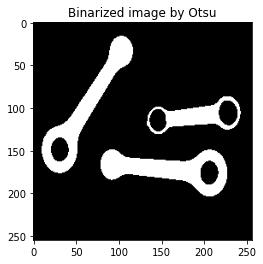

In [5]:
threshold, binary_image = cv2.threshold(filtered_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.title("Binarized image by Otsu")
plt.imshow(binary_image, cmap='gray')
plt.show()

# Labelling
To better visualise the labelling procedure we plot the image such that different labelled blobs carry different colors. This intermediate step is done to analyse each component separately.
The `connectedComponentsWithStats()` function of OpenCV returns different elements such that:
* the number of connected components
* the labelled image 
* Some statistics
* The coordinates of the centroid for each component

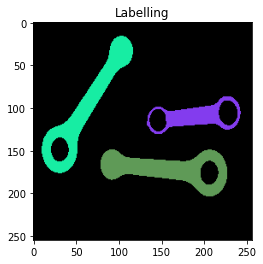

In [6]:
number_of_components, output_labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, 4, cv2.CV_32S)
rgb_image = cv2.cvtColor(output_labels.astype(np.uint8), cv2.COLOR_GRAY2RGB)
labelled_img = rgb_image.copy()
labels = np.unique(output_labels)[1:]

for i in labels:
    rgb_label = [rand.randint(0,256), rand.randint(0,256), rand.randint(0,256)]
    labelled_img = np.where(rgb_image == i, rgb_label, labelled_img)

plt.title("Labelling")
plt.imshow(labelled_img)
plt.show()

# Blob Analysis

## Finding contour of blobs
In order to compute the MER (Minimum Enclosing Rectangle) for each blob it is necessary to find the contours.  
The `findContours()` function of OpenCV returns $n$ contours as well as an $n \times 4$ matrix called `hierarchy`. Thanks to this matrix it is possible to reconstruct which contours are enclosed in outer contours. Essentially it is possible to understand if a contour has any inner contour and in which row of the matrix it is possible to find it.  
To fully exploit the informations given by this data structure is important to well understand its content:
* Each row represents a contour
* The first column represents the row index of the next contour at the same level
* The second column represents the row index of the previous node at the same level
* The third row represents the row index of the next child
* The fourth row represents the row index of the parent
* If the entry's value is -1, it means that the value is not present

Notice that when referring to the next or previous contour it means with respect to the ordered position of the given element, row wise.

In [7]:
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hierarchy=hierarchy[0]
print(hierarchy)

[[ 2 -1  1 -1]
 [-1 -1 -1  0]
 [ 5  0  3 -1]
 [ 4 -1 -1  2]
 [-1  3 -1  2]
 [-1  2  6 -1]
 [-1 -1 -1  5]]


## Classification of rods
To classify a rod it is necessary to count how many holes it has inside itself. This can be easily achieved by counting the numbers of contours inside each outer contour.  
The `number_of_holes()` function has two parameters: the `hierarchy` matrix and the current contour for which the number of holes is computed.  

To compute the number of holes for each contour it has been used the `hierarchy` matrix that contains all the needed information. Looking at the third column it is possible to check whether a contour has other contours inside itself, this is done by checking if the value in the given column is different from $-1$, in that case the number of holes is incremented.  
Then, by looking in the first column it is possible to count all the other contours at the same level, in other words all the other holes inside the given contour.

Finally, once the number of holes has been computed, the rod is simply classified and the corresponding label is stored in a dictionary.

In [8]:
dict_class_contours = {}

def number_of_holes(hierarchy, contour):
    n_holes = 0
    
    if hierarchy[contour][2] != -1:
        n_holes += 1
        contour += 1
        while hierarchy[contour][0] != -1:
            contour += 1
            n_holes += 1
    return n_holes

for i in range(len(contours)):
    
    n_holes = number_of_holes(hierarchy, i)

    if n_holes == 1:
        dict_class_contours[i] = 'Rod_A'
    elif n_holes == 2:
        dict_class_contours[i] = 'Rod_B'
    else:
        dict_class_contours[i] = 'Hole'
    
print("Blobs' class:", dict_class_contours)

Blobs' class: {0: 'Rod_A', 1: 'Hole', 2: 'Rod_B', 3: 'Hole', 4: 'Hole', 5: 'Rod_A', 6: 'Hole'}


## Finding enclosing rectangles
In order to find the minimum enclosing rectangle for outer contours and the minimum enclosing ellipse for inner contours it has been used two functions in OpenCV: 
* `minAreaRect()`
* `fitEllipse()`

These two functions return a list of $n$ elements, where $n$ is the number of contours.  
In the first case each element in the list contains: position, width and height, and the orientation for each MER.  
In the second case each element in the list contains: position, width and height, and the orientation of the rotated rectangle in which the ellipse is inscribed.

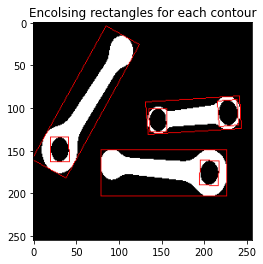

In [9]:
enclosing_rectangles = {}
drawing_er = binary_image.copy()
drawing_er = cv2.cvtColor(drawing_er.astype(np.uint8), cv2.COLOR_GRAY2RGB)
color = (255,0,0)

for i, c in enumerate(contours):
    if dict_class_contours[i] == 'Rod_A' or dict_class_contours[i] == 'Rod_B':
        enclosing_rectangles[i] = cv2.minAreaRect(c)
    else:
        enclosing_rectangles[i]= cv2.fitEllipse(c)
        
    box = cv2.boxPoints(enclosing_rectangles[i])
    box = np.round(box).astype(int)
    cv2.drawContours(drawing_er, [box], 0, color, thickness=1)

plt.title("Encolsing rectangles for each contour")
plt.imshow(drawing_er, cmap='gray')
plt.show()

## Barycenter of rods
The coordinates of the barycenters for each rod are stored in `centroids`, however there is no correspondence between classified rods and their label as connected components.  
To solve this issue it has been taken one pixel from the contour of each rod and by checking its label in `output_labels`, which is the connected component labelled image, it has been possible to find the index of the desired barycenter in `centroids`.  
Finally the centroids are rounded to the nearest integer to get discrete coordinates.

Barycenters for each rod: {0: (157, 172), 2: (190, 110), 5: (62, 99)}


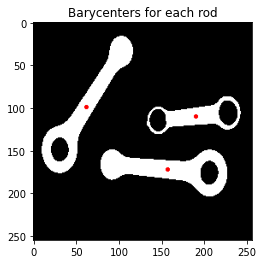

In [10]:
dict_rods_barycenter = {}

drawing_barycenter = binary_image.copy()
drawing_barycenter = cv2.cvtColor(drawing_barycenter.astype(np.uint8), cv2.COLOR_GRAY2RGB)
color = (255,0,0)

for i in range(len(contours)):
    if dict_class_contours[i] == 'Rod_A' or dict_class_contours[i] == 'Rod_B':
        cords = contours[i][0]
        x = cords[0][0]
        y = cords[0][1]
        label = output_labels[y][x]
        centroid_x = round(centroids[label][0])
        centroid_y = round(centroids[label][1])
        
        dict_rods_barycenter[i] = (centroid_x, centroid_y)
        cv2.circle(drawing_barycenter, dict_rods_barycenter[i], 1, color, thickness=2)


print("Barycenters for each rod:", dict_rods_barycenter)
plt.title("Barycenters for each rod")
plt.imshow(drawing_barycenter, cmap='gray')
plt.show()

## Length, width and orientation of rods
The `minAreaRect()` function of OpenCV returns length, width and orientation of each rod, however some returned values have to be manipulated a bit. Indeed this function returns the angles of the rotated rectangle in an interval beatween 0 and 90 degrees with respect to the the orizontal axis and the first axis that it encounters clockwise, independently if the considered axis is the major or the minor axis.   
For this reason if is the width is greater than the length the two measures have to be swapped, otherwise it is only necessary to convert the angle in an interval between 0 and 180 degrees with respect to the major axis, counterclockwise.

In [11]:
dict_rods_length = {}
dict_rods_width = {}
dict_rods_orientation = {}

for i in range(len(contours)):
    if dict_class_contours[i] == 'Rod_A' or dict_class_contours[i] == 'Rod_B':
        dict_rods_width[i] = round(enclosing_rectangles[i][1][0], 2)
        dict_rods_length[i] = round(enclosing_rectangles[i][1][1], 2)
            
        if (dict_rods_width[i] > dict_rods_length[i]):
            dict_rods_orientation[i] = round((180-enclosing_rectangles[i][2]), 2)
            temp = dict_rods_width[i]
            dict_rods_width[i] = dict_rods_length[i]
            dict_rods_length[i] = temp
        else:
            dict_rods_orientation[i] = round((90-enclosing_rectangles[i][2]), 2)
        
print("Orientation:", dict_rods_orientation)
print("Length:", dict_rods_length)
print("Width", dict_rods_width)

Orientation: {0: 0.0, 2: 3.62, 5: 61.06}
Length: {0: 147.0, 2: 109.79, 5: 178.62}
Width {0: 54.0, 2: 38.37, 5: 44.85}


## Center and diameter of holes
The coordinates of the center for each hole are returned by the `fitEllipse()` function of OpenCV. While computing the diameter it has been computed the mean between the width and the height of the rotated rectangle returned by the function. This is done due to the fact that the holes do not have a perfectly circular shape, therefore an approximation is required.  

In [12]:
dict_holes_center = {}
dict_holes_diameter = {}

for i in range(len(contours)):
    if dict_class_contours[i] == 'Hole':
        x_hole_center = round(enclosing_rectangles[i][0][0])
        y_hole_center = round(enclosing_rectangles[i][0][1])
        dict_holes_center[i] = (x_hole_center, y_hole_center)
        dict_holes_diameter[i] = round(mean(enclosing_rectangles[i][1]), 2)

print("Holes' center:", dict_holes_center)
print("Holes' diameter:", dict_holes_diameter)

Holes' center: {1: (206, 176), 3: (146, 114), 4: (228, 106), 6: (31, 149)}
Holes' diameter: {1: 25.44, 3: 24.04, 4: 26.56, 6: 25.38}


## Width at the barycenter
To compute the width at the barycenter, firstly it has been found the distances for each point of the contour with respect to the barycenter. Then once that a list of all the distances is computed, because the rods are symmetric with respect to the major axis, it is sufficient to find the minimum distance and double it.

In [13]:
dict_barycenter_width = {}

for i in range(len(contours)):
    if dict_class_contours[i] == 'Rod_A' or dict_class_contours[i] == 'Rod_B':
        points_dist = []
        barycenter = np.array(dict_rods_barycenter[i])
        
        for contour_point in contours[i]:
            contour_point = contour_point[0]
            points_dist.append(np.linalg.norm(barycenter - contour_point))
            
        min_distance = min(points_dist)
        dict_barycenter_width[i] = round(min_distance * 2, 2)

print("Width at the barycenter:", dict_barycenter_width)

Width at the barycenter: {0: 20.1, 2: 18.11, 5: 16.12}


## Display the results
Visualization and summary of all the computed measures

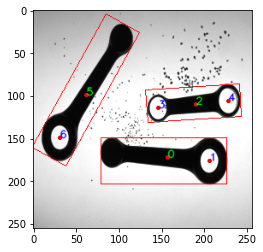

          ROD: 0
Class: Rod_A
Position: (157, 172)
Orientation: 0.0
Lenght: 147.0
Width: 54.0
Width at the barycenter : 20.1
***************************************************
          HOLE: 1
Center coordiantes: (206, 176)
Diameter: 25.44
***************************************************
          ROD: 2
Class: Rod_B
Position: (190, 110)
Orientation: 3.62
Lenght: 109.79
Width: 38.37
Width at the barycenter : 18.11
***************************************************
          HOLE: 3
Center coordiantes: (146, 114)
Diameter: 24.04
***************************************************
          HOLE: 4
Center coordiantes: (228, 106)
Diameter: 26.56
***************************************************
          ROD: 5
Class: Rod_A
Position: (62, 99)
Orientation: 61.06
Lenght: 178.62
Width: 44.85
Width at the barycenter : 16.12
***************************************************
          HOLE: 6
Center coordiantes: (31, 149)
Diameter: 25.38
***********************************************

In [14]:
drawing_info = image.copy()
drawing_info = cv2.cvtColor(drawing_info.astype(np.uint8), cv2.COLOR_GRAY2RGB)
color = (255,0,0)
font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(len(contours)):
    if dict_class_contours[i] == 'Rod_A' or dict_class_contours[i] == 'Rod_B':
        box = cv2.boxPoints(enclosing_rectangles[i])
        box = np.round(box).astype(int)
        cv2.drawContours(drawing_info, [box], 0, color, thickness=1)
        cv2.circle(drawing_info, dict_rods_barycenter[i], 1, color, thickness=2)
        cv2.putText(drawing_info, str(i), dict_rods_barycenter[i], font, 0.4,(0,255,0),1,cv2.LINE_AA)
        
    else:
        cv2.circle(drawing_info, dict_holes_center[i], 1, color, thickness=2)
        cv2.putText(drawing_info, str(i), dict_holes_center[i], font, 0.4,(0,0,255),1,cv2.LINE_AA)

plt.imshow(drawing_info)
plt.show()

for i in range(len(contours)):
    if dict_class_contours[i] == 'Rod_A' or dict_class_contours[i] == 'Rod_B':
        print("          ROD:", i)
        print("Class:", dict_class_contours[i])
        print("Position:", dict_rods_barycenter[i])
        print("Orientation:", dict_rods_orientation[i])
        print("Lenght:", dict_rods_length[i])
        print("Width:", dict_rods_width[i])
        print("Width at the barycenter :", dict_barycenter_width[i])
        print("***************************************************")
    else:
        print("          HOLE:", i)
        print("Center coordiantes:", dict_holes_center[i])
        print("Diameter:", dict_holes_diameter[i])
        print("***************************************************")